# Prediction of Bike Sharing Demand 
##### *(Matthew Holmes, Andrew Kabatznick, Grant Whittington)*
## Problem Description

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

**Part 1: Predicting Rental Test Data from Train Data**  
We are provided with hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Hourly rental data spanning two years has been provided. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set.  

**Part 2: Predicting Future Rentals from Past Data**  
In this part we expolore a scenario where a bicycle rental company which has been around for a few years and is looking to optimize their bike rentals over various sites in a city.  From day to day, different amounts of bikes are rented based on a number of factors, and accurate prediction of that number will allow for bikes to be redistributed among sites, leading to a higher use rate and more profits.  The initial dataset will be that of the rentals per hour at the site, and corresponding date/time information and related weather factors.  After the initial model is created, “on-line” features will be implemented, allowing new data to be used in prediction of future data.

[Kaggel Competition Overview](https://www.kaggle.com/c/bike-sharing-demand)   
[Kaggel Competition Data](https://www.kaggle.com/c/bike-sharing-demand/data)

## Libraries

In [22]:
#Libraries needed for analysis 
%matplotlib inline

#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from subprocess import check_output
import calendar
import math

#sklearn libraries
from sklearn.cross_validation import cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#supress warngings in some cases
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Bike Share EDA

**Load Dataset**

**Data Fields Provided**

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** -  
  1: Clear, Few clouds, Partly cloudy, Partly cloudy  
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals

In [23]:
BikeData = pd.read_csv("./train.csv")

In [24]:
BikeData.shape

(10886, 12)

**Data Types of the Variables**

In [25]:
BikeData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Extacts the time features from the datetime for more robust analysis

In [26]:
#Convert BikeData.datetime to datetime
BikeData.datetime = pd.to_datetime(BikeData.datetime)
#Extract Month
BikeData['month'] = BikeData.datetime.dt.month
#Extract Hour
BikeData['hour'] = BikeData.datetime.dt.hour

### Defines the categorical variables as categorical variables and then displays the datatypes to confirm the data definitions

In [27]:
categoryVariableList = ["hour","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    BikeData[var] = BikeData[var].astype("category")
BikeData.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
month               category
hour                category
dtype: object

### Plots of Weather Condition, Season, Month, and Day Type by User Type by Time

In [28]:
#Defines Dictionaries to Help Convert our data into Human Readable Labels
WeatherTypes = {
                1: 'No Precipitation',
                2: 'Light Precipitation',
                3: 'Medium Precipitation',
                4: 'Heavy Precipitation'
            }

Season = {
 1: 'Winter',
 2: 'Spring', 
 3: 'Summer', 
 4: 'Fall', 
}

WorkingDay = {
    0:'Non-Business Day',
    1:'Business Day'  
}

#Builds Help Functions for Plotting our data
def transform_data(TempBikeData,UserType="All"):
    #Makes a copy of the Dataframe so that our deletes don't happen on the underlying dataframe
    TempBikeData = TempBikeData.copy()
    #If the UserType is Casual then our analysis will be only on the Casual Users
    if UserType == 'Casual':
        TempBikeData.loc[:,'count'] = TempBikeData['casual']
    #If the UserType is Registered then we only look at the Registered Users
    elif UserType == 'Registered':
        TempBikeData.loc[:,'count'] = TempBikeData['registered']
    #Delete unnecassary variables
    del TempBikeData['casual']
    del TempBikeData['registered']
    
    #Find Average number of riders by month
    MonthAggregated = pd.DataFrame(TempBikeData.groupby("month")["count"].mean()).reset_index()
    #Label the Month in the MMM format
    MonthAggregated.month = MonthAggregated.month.apply(lambda x: calendar.month_abbr[x])
    
    #Find average number of riders by Season
    SeasonAggregated = pd.DataFrame(TempBikeData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
    #Label the Season. Note the label's here: https://www.kaggle.com/c/bike-sharing-demand/data are incorrect.
    SeasonAggregated.season = SeasonAggregated.season.apply(lambda x: Season[x])
    
    #Find the average number of riders for workingdays vs. non-working days
    WorkDayAggregated = pd.DataFrame(TempBikeData.groupby(["hour","workingday"],sort=True)["count"].mean()).reset_index()
    #Label's the binary variable as text
    WorkDayAggregated.workingday = WorkDayAggregated.workingday.apply(lambda x: WorkingDay[x])
    
    #Find the average number of riders by weather
    WeatherAggregated = pd.DataFrame(TempBikeData.groupby(["hour","weather"],sort=True)["count"].mean()).reset_index()
    #Converts this into a more readable format
    WeatherAggregated.weather = WeatherAggregated.weather.apply(lambda x: WeatherTypes[x])

    return MonthAggregated, SeasonAggregated, WorkDayAggregated, WeatherAggregated
    
def data_plots(i,user_type,MonthAggregated,SeasonAggregated,WorkDayAggregated,WeatherAggregated):
    #Defines the subplot, we will be plotting to
    ax = plt.subplot(3,4, i*4+1)
    #Plots the Month Data and Labels it
    _ =sns.barplot(data=MonthAggregated,x="month",y="count",ax=ax)
    _ = ax.set(xlabel='Month', ylabel='Average User Count')
    ax.set_title("Average {} User Count By Month".format(user_type),fontsize=20)
    
    #Plots the Season Data
    ax = plt.subplot(3,4, i*4+2)
    _ = sns.pointplot(x=SeasonAggregated["hour"], y=SeasonAggregated["count"],hue=SeasonAggregated["season"], 
                     data=SeasonAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour by Season".format(user_type),fontsize=20)
    
    #Plots the Work Day Data
    ax = plt.subplot(3,4, i*4+3)
    _ = sns.pointplot(x=WorkDayAggregated["hour"], y=WorkDayAggregated["count"],
                     hue=WorkDayAggregated["workingday"], data=WorkDayAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour for \n Workdays vs. Non Work Days".format(user_type),fontsize=20)
    
    #Plots the Weather Data
    ax = plt.subplot(3,4, i*4+4)
    _ = sns.pointplot(x=WeatherAggregated["hour"], y=WeatherAggregated["count"],
                     hue=WeatherAggregated["weather"], data=WeatherAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour by Weather".format(user_type),fontsize=20)

### Basic EDA by Month, Workday, Season, and Weather

As we can see based on the plots below there are significant differences in the behavior of casual users compared with the behaviour of registered users. Given these differences, it makes sense to build two generative models, one for causal users and one for registered users. Once we have built these predictions we can then add these two outputs together to help determine our total count.

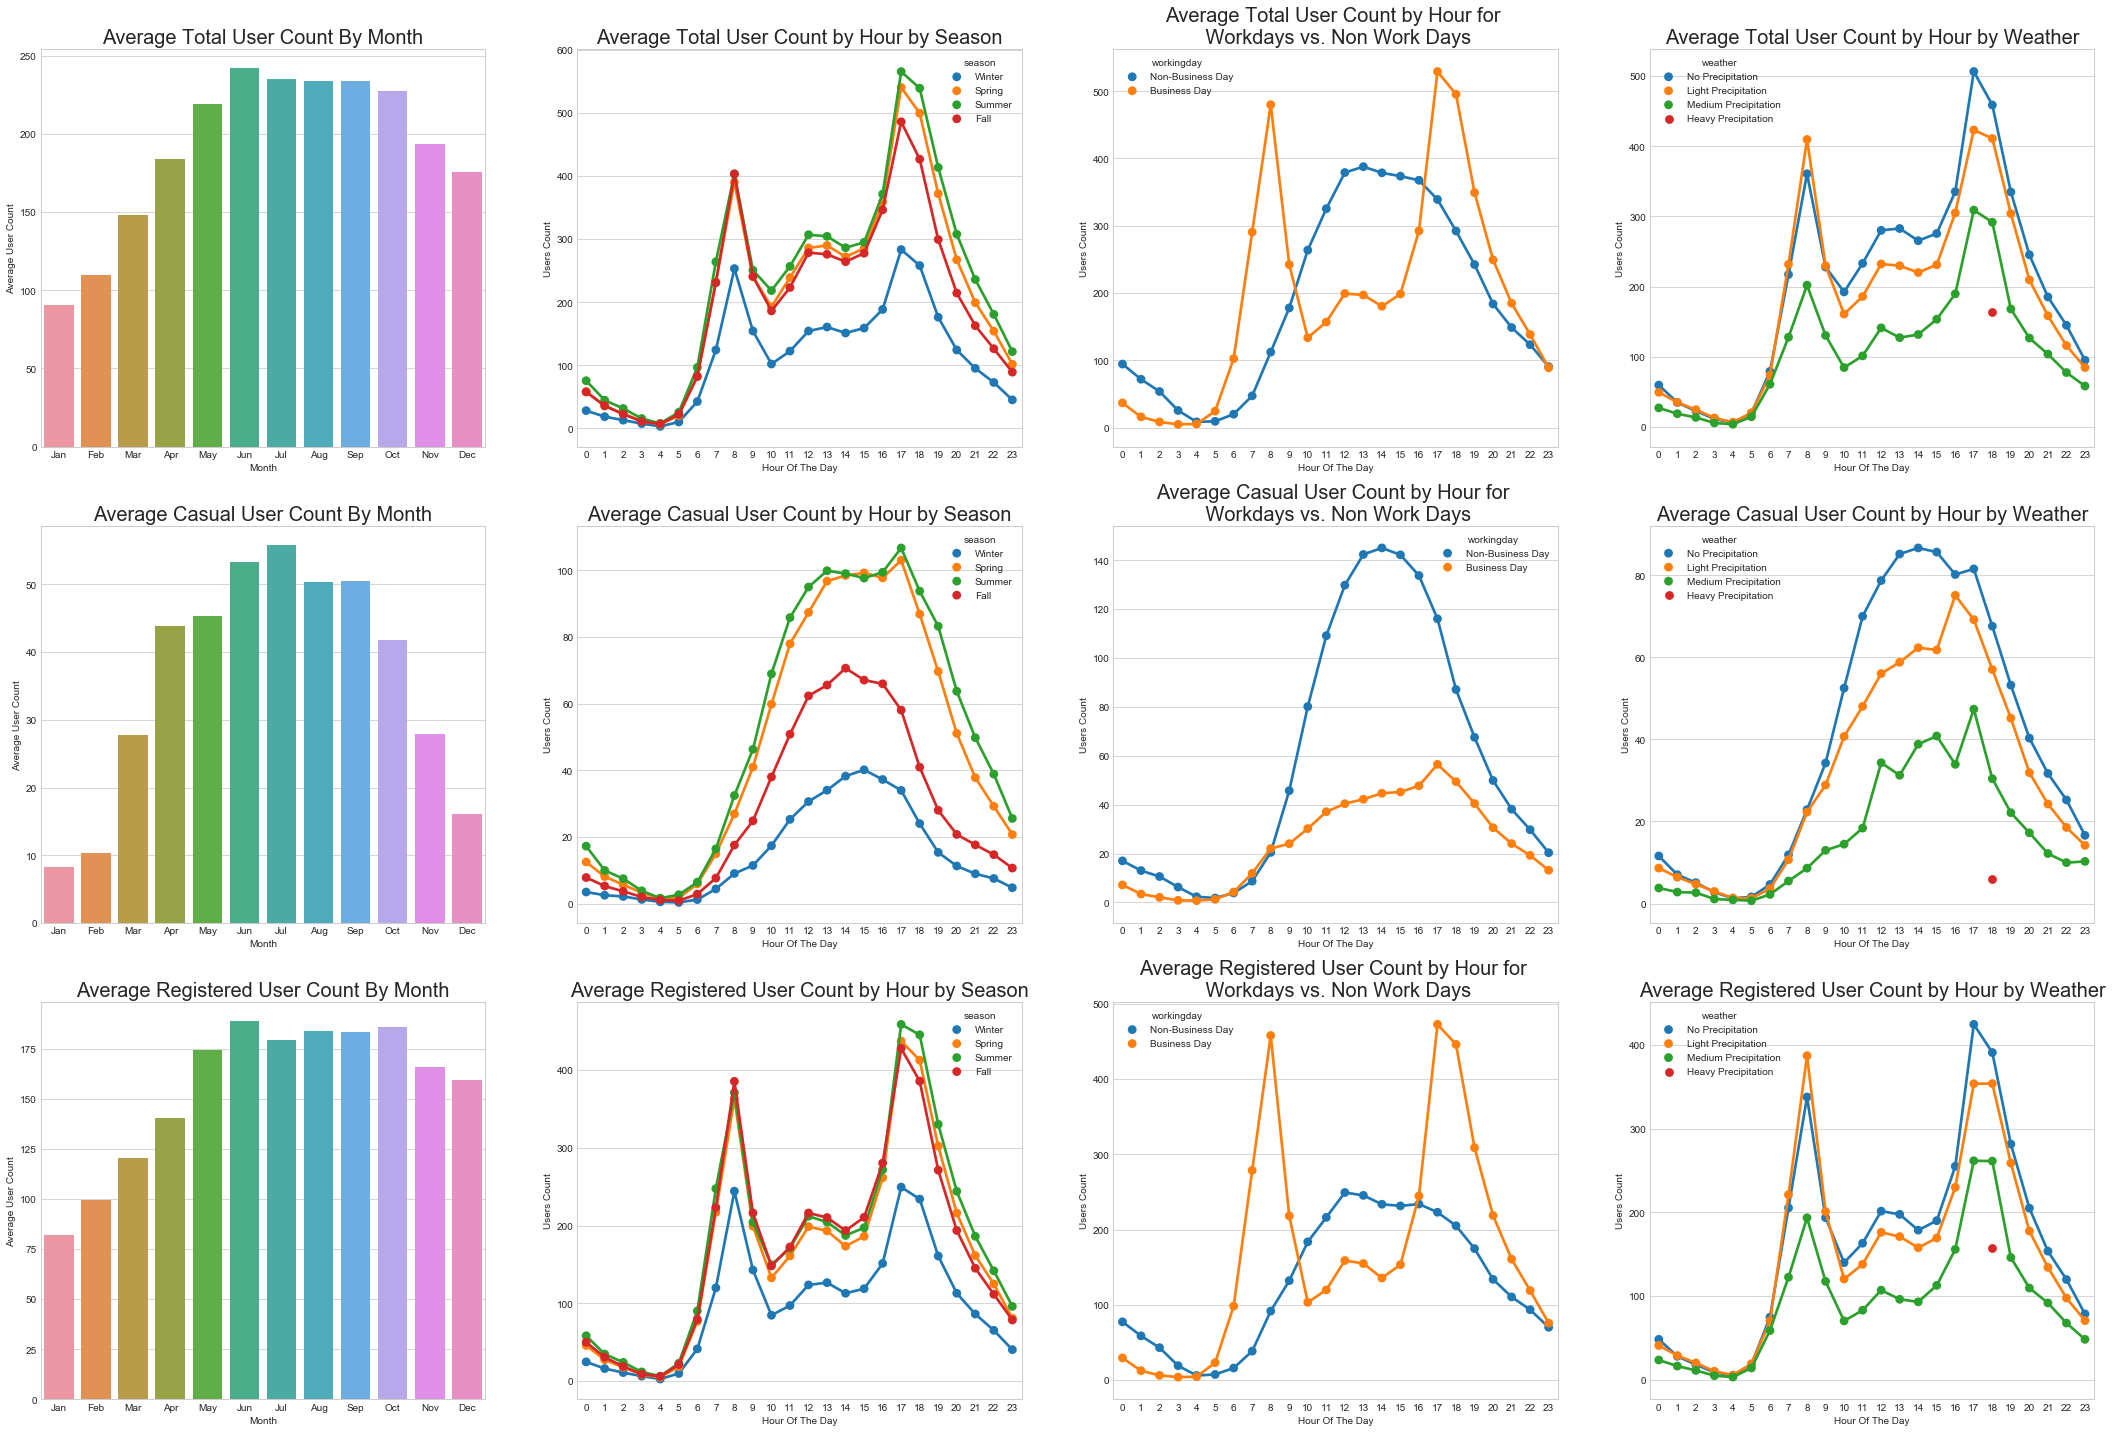

In [29]:
UserTypes = ['Total','Casual','Registered']
ax, fig = plt.subplots(3,4,figsize=(30,20))

for i,UType in enumerate(UserTypes):
    #Calls the functions defined above to plot the basic data
    MonthAggregated, SeasonAggregated, WorkDayAggregated, WeatherAggregated = transform_data(BikeData,UType)
    data_plots(i,UType,MonthAggregated,SeasonAggregated,WorkDayAggregated,WeatherAggregated)
plt.tight_layout()

In [30]:
#Transforms the Dataframes
def break_out_users(BikeData):
    Casual = BikeData.copy()
    Registered = BikeData.copy()

    del Casual['count']
    del Casual['registered']

    del Registered['count']
    del Registered['casual']

    Casual.rename(columns={'casual': 'count'}, inplace=True)
    Registered.rename(columns={'registered': 'count'}, inplace=True)
    return Casual, Registered

Casual, Registered = break_out_users(BikeData)

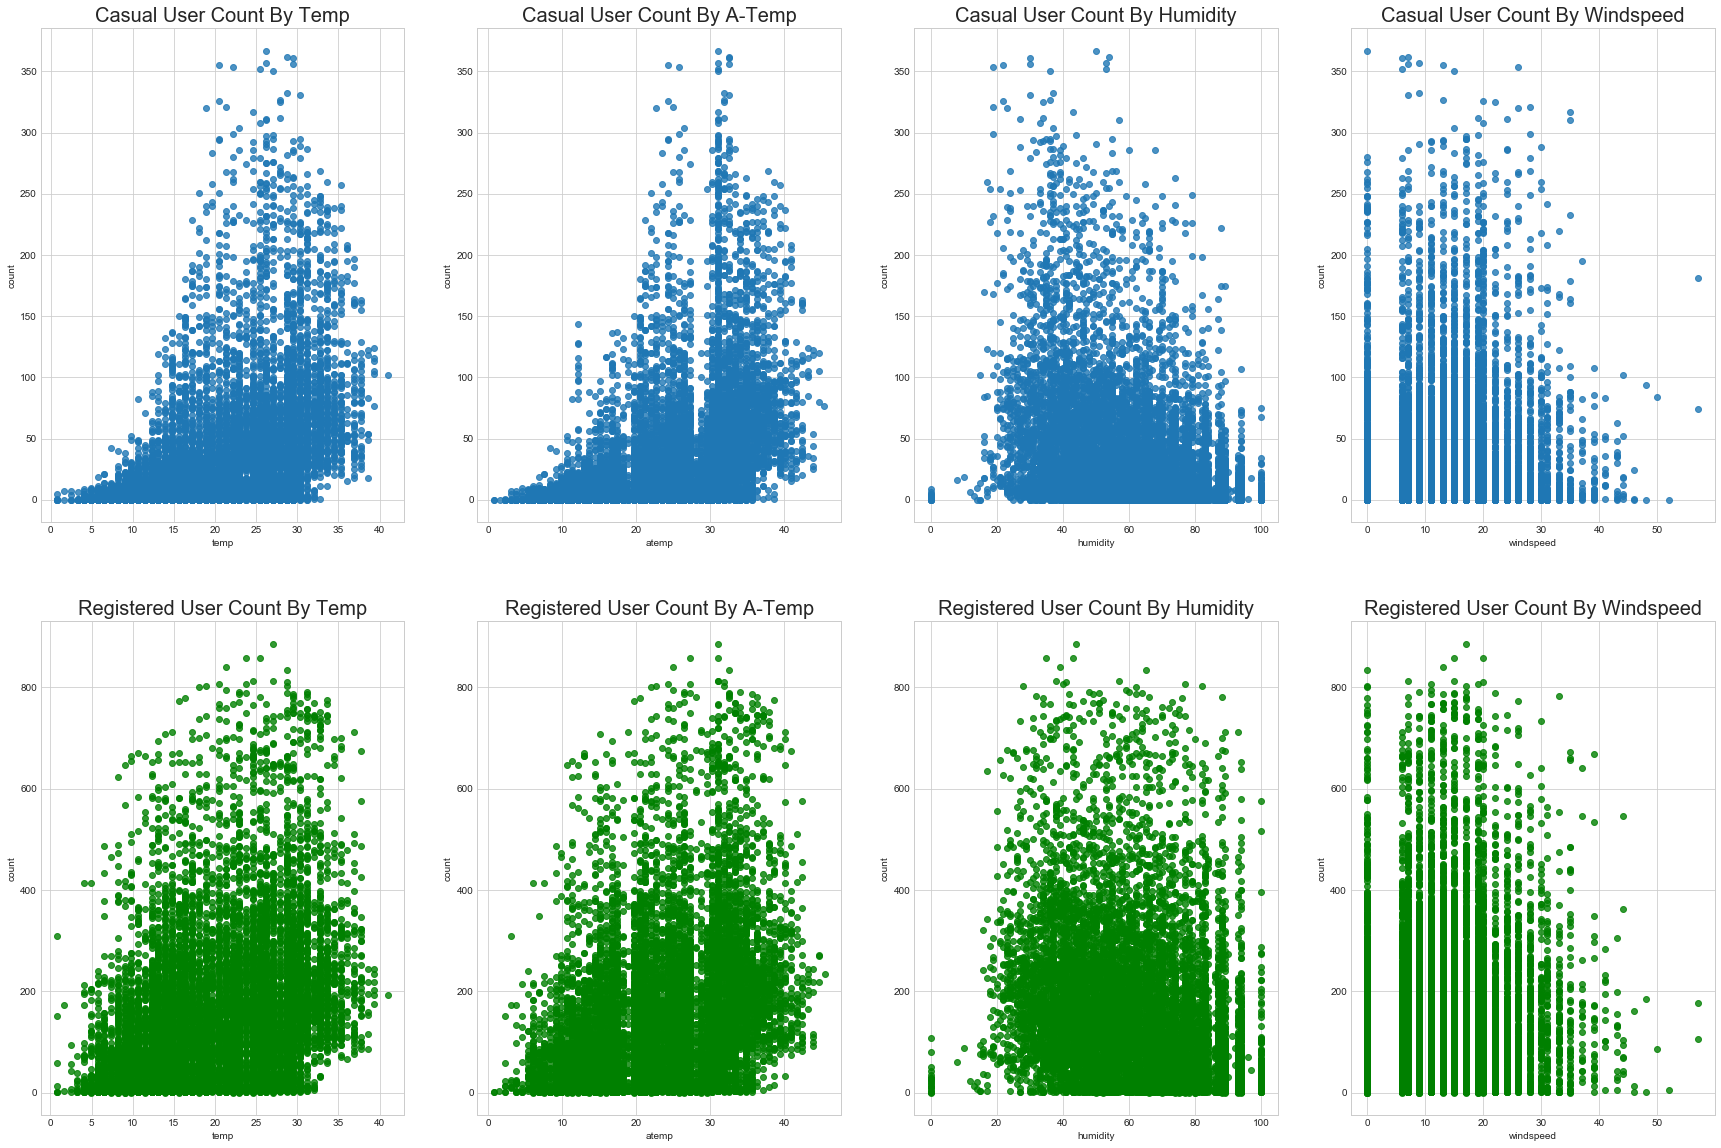

In [31]:
#Still working on this   
UserTypes = ['Casual','Registered']
ax, fig = plt.subplots(2,4,figsize=(30,20))


#Causal Users
ax = plt.subplot(2,4, 1)
_ = sns.regplot('temp', 'count',data=Casual, fit_reg=False,ax=ax)
_ = ax.set_title("Casual User Count By Temp",fontsize=20)

ax = plt.subplot(2,4, 2)
_ = sns.regplot('atemp', 'count',data=Casual, fit_reg=False,ax=ax)
_ = ax.set_title("Casual User Count By A-Temp",fontsize=20)

ax = plt.subplot(2,4, 3)
_ = sns.regplot('humidity', 'count',data=Casual, fit_reg=False,ax=ax)
_ = ax.set_title("Casual User Count By Humidity",fontsize=20)

ax = plt.subplot(2,4, 4)
_ = sns.regplot('windspeed', 'count',data=Casual, fit_reg=False,ax=ax)
_ = ax.set_title("Casual User Count By Windspeed",fontsize=20)


#Registered Users
ax = plt.subplot(2,4, 5)
_ = sns.regplot('temp', 'count',data=Registered, fit_reg=False,ax=ax,color='green')
_ = ax.set_title("Registered User Count By Temp",fontsize=20)

ax = plt.subplot(2,4, 6)
_ = sns.regplot('atemp', 'count',data=Registered, fit_reg=False,ax=ax,color='green')
_ = ax.set_title("Registered User Count By A-Temp",fontsize=20)

ax = plt.subplot(2,4, 7)
_ = sns.regplot('humidity', 'count',data=Registered, fit_reg=False,ax=ax,color='green')
_ = ax.set_title("Registered User Count By Humidity",fontsize=20)

ax = plt.subplot(2,4, 8)
_ = sns.regplot('windspeed', 'count',data=Registered, fit_reg=False,ax=ax,color='green')
_ = ax.set_title("Registered User Count By Windspeed",fontsize=20)

# Part 1: Predicting Rental Test Data from Train Data

## Baseline Data Analysis

The data is loaded and viewed below for the train and test dataset.  From the train dataset we can see that casual, registered, and count are our dependent variables.  The shapes of the data and the features are also shown below.

In [32]:
#reloading and Viewing the data to start out fresh and including the test data
df_train = pd.read_csv('train.csv', parse_dates=[0], index_col=0)
print 'Training Data:'
print df_train.head()
print 
df_test = pd.read_csv('test.csv', parse_dates=[0], index_col=0)
print 'Test Data:'
print df_test.head()
print
print 'Shape of training data:'
print df_train.shape
print 
print 'Shape of test data'
print df_test.shape
print 
features = df_train.columns.values[:-3]
print 'Training data features:'
print features

Training Data:
                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40  
2011-01-01 02:00:00        80        0.0       5          27     32  
2011-01-01 03:00:00        75        0.0       3          10     13  
2011-01-01 04:00:00        75        0.

### Baseline
The preferred Kaggle evaluation criteria is RMSLE as defined by the competition. First we start by prediction the outcome variable with its median set the baseline. We will use a 10-fold cross validation, to balance between training a good model with low bias and having sufficient test examples to check accuracy.  Our RMSLE is comparable to the Kaggle submission score, so we will use the RMSLE as a standard for model accuracy.  

In [33]:
#Kaggle Evaluation Criteria: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

In [34]:
#Baseline prediction using a median model
base_median_model = DummyRegressor(strategy="median")
base_median_preds = cross_val_predict(base_median_model, df_train[features], df_train['count'], cv=10)

kaggle_fit_base_median = base_median_model.fit(df_train[features], df_train['count'])
kaggle_predict_base_median = base_median_model.predict(df_test[features])

base_median_RMSLE = RMSLE(df_train['count'], base_median_preds)
base_median_R2 = metrics.r2_score(df_train['count'], base_median_preds)

print 'Baseline median RMSLE: ', base_median_RMSLE
print 'Baseline median R2: ', base_median_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_predict_base_median}, columns = ["datetime", "count"])
df_submission.to_csv('base_median_bike_sharing_prediction_output.csv', index=False)

Baseline median RMSLE:  1.4895164464
Baseline median R2:  -0.101736402547


### Linear Regression
Next we will use linear regression to see if we can improve upon the median baseline.

In [35]:
#Linear regression prediction
base_LR_model = LinearRegression()
base_LR_preds = cross_val_predict(base_LR_model, df_train[features], df_train['count'], cv=10)
base_LR_preds[base_LR_preds<0] = 0

kaggle_LR_fit_base_LR = base_LR_model.fit(df_train[features], df_train['count'])
kaggle_LR_predict_base_LR = base_LR_model.predict(df_test[features])
kaggle_LR_predict_base_LR[kaggle_LR_predict_base_LR<0] = 0

base_LR_RMSLE = RMSLE(df_train['count'], base_LR_preds)
base_LR_R2 = metrics.r2_score(df_train['count'], base_LR_preds)

print 'Baseline linear regression RMSLE: ', base_LR_RMSLE
print 'Baseline linear regression R2: ', base_LR_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_base_LR}, columns = ["datetime", "count"])
df_submission.to_csv('lr_bike_sharing_prediction_output.csv', index=False)

Baseline linear regression RMSLE:  1.46411819396
Baseline linear regression R2:  0.202176907265


Linear regression is able to bring down the RMSLE 0.02 and improve R2 to 10%, which is a modest improvement.

## Feature Engineering

In [36]:
#Put the train and test dataset togeather to create new features
data = df_train.append(df_test)
print 'Train and test data combined:'
print 
print data.head()
print
print 'Data shape:'
print 
print data.shape

Train and test data combined:

                      atemp  casual  count  holiday  humidity  registered  \
datetime                                                                    
2011-01-01 00:00:00  14.395     3.0   16.0        0        81        13.0   
2011-01-01 01:00:00  13.635     8.0   40.0        0        80        32.0   
2011-01-01 02:00:00  13.635     5.0   32.0        0        80        27.0   
2011-01-01 03:00:00  14.395     3.0   13.0        0        75        10.0   
2011-01-01 04:00:00  14.395     0.0    1.0        0        75         1.0   

                     season  temp  weather  windspeed  workingday  
datetime                                                           
2011-01-01 00:00:00       1  9.84        1        0.0           0  
2011-01-01 01:00:00       1  9.02        1        0.0           0  
2011-01-01 02:00:00       1  9.02        1        0.0           0  
2011-01-01 03:00:00       1  9.84        1        0.0           0  
2011-01-01 04:00:00  

### Datetime Features

The Datetime column contains a lot of data that can be split out into separate columns to be used as features for modeling.

In [37]:
#Making new features from the datetime column
data["year"] = data.index.year
data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek
data["month"] = data.index.month
data["day"] = data.index.day
data["dayofyear"] = data.index.dayofyear
data['weekend'] = np.where((data['dayofweek'] == 5) | (data['dayofweek'] == 6), 1, 0)
data['day_type'] = np.where((data['holiday'] == 0) & (data['workingday'] == 0), 0, (np.where((data['holiday'] == 0) & (data['workingday'] == 1), 1, 2)))
data.head()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,hour,dayofweek,month,day,dayofyear,weekend,day_type
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,3.0,16.0,0,81,13.0,1,9.84,1,0.0,0,2011,0,5,1,1,1,1,0
2011-01-01 01:00:00,13.635,8.0,40.0,0,80,32.0,1,9.02,1,0.0,0,2011,1,5,1,1,1,1,0
2011-01-01 02:00:00,13.635,5.0,32.0,0,80,27.0,1,9.02,1,0.0,0,2011,2,5,1,1,1,1,0
2011-01-01 03:00:00,14.395,3.0,13.0,0,75,10.0,1,9.84,1,0.0,0,2011,3,5,1,1,1,1,0
2011-01-01 04:00:00,14.395,0.0,1.0,0,75,1.0,1,9.84,1,0.0,0,2011,4,5,1,1,1,1,0


### Imputing Humidity and Windspeed

Windspeed and humidity have a large number of zero values that should not be present.  We can use Random Forests to impute the values for these data, which may improve the accuracy of our modeling. 

In [38]:
#Imputing windspeed to fill in the zero values
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rf_Model_wind = RandomForestClassifier()
rf_Model_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rf_Model_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


 None]

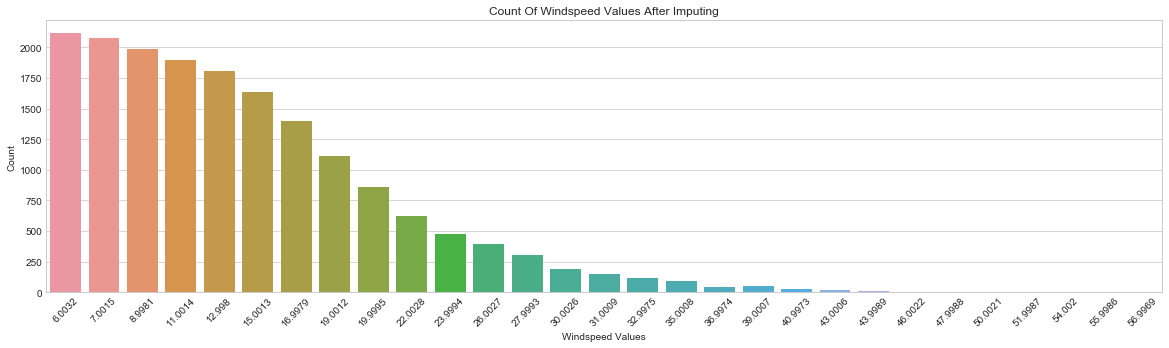

In [39]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sns.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

In [40]:
#Imputing humidity to fill in the zero values
from sklearn.ensemble import RandomForestClassifier

humidityColumns = ["season","weather","windspeed","month","temp","year","atemp"]
datahumidity0 = data[data["humidity"]==0]
datahumidityNot0 = data[data["humidity"]!=0]
datahumidityNot0["humidity"] = datahumidityNot0["humidity"].astype("str")

rf_Model_humidity = RandomForestClassifier()
rf_Model_humidity.fit(datahumidityNot0[humidityColumns], datahumidityNot0["humidity"])
humidity0Values = rf_Model_humidity.predict(X= datahumidity0[humidityColumns])

datahumidity0["humidity"] = humidity0Values
data = datahumidityNot0.append(datahumidity0)
data["humidity"] = data["humidity"].astype("float")

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


 None]

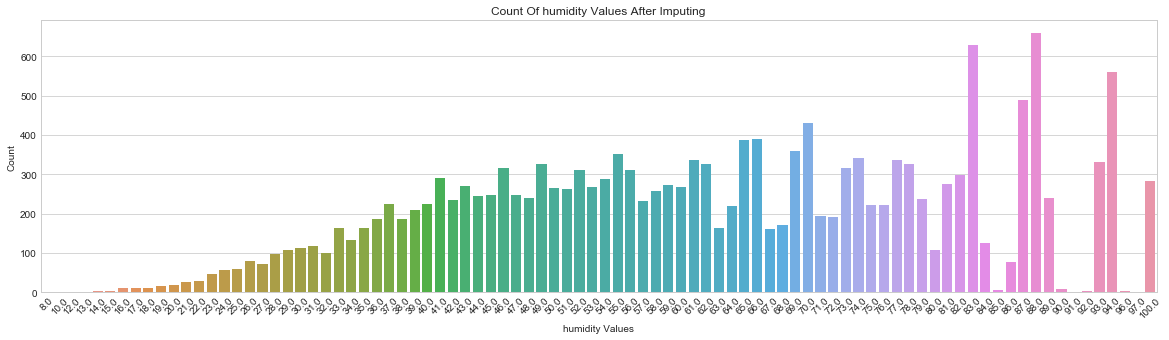

In [41]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
humidity = pd.DataFrame(data.humidity.value_counts()).reset_index()
plt.xticks(rotation=45) 
sns.barplot(data=humidity,x="index",y="humidity",ax=ax)
ax.set(xlabel='humidity Values', ylabel='Count',title="Count Of humidity Values After Imputing",label='big')

In [42]:
#check to make sure that the imputation transfered the dataframe
result = data.apply(pd.value_counts).fillna(0)
print result.head()

       atemp  casual  count  holiday  humidity  registered  season  temp  \
0.000    2.0   986.0    0.0  16879.0       0.0        15.0     0.0   0.0   
0.760    4.0     0.0    0.0      0.0       0.0         0.0     0.0   0.0   
0.820    0.0     0.0    0.0      0.0       0.0         0.0     0.0  17.0   
1.000    0.0   667.0  105.0    500.0       0.0       135.0  4242.0   0.0   
1.515    8.0     0.0    0.0      0.0       0.0         0.0     0.0   0.0   

       weather  windspeed  workingday  year   hour  dayofweek   month    day  \
0.000      0.0        0.0      5514.0   0.0  726.0     2479.0     0.0    0.0   
0.760      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   
0.820      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   
1.000  11413.0        0.0     11865.0   0.0  724.0     2453.0  1429.0  575.0   
1.515      0.0        0.0         0.0   0.0    0.0        0.0     0.0    0.0   

       dayofyear  weekend  day_type  
0.000        0.0  12365.

In [43]:
#split the data into df_train and df_test by day of the month
df_train = data.loc[data['day'] < 20]
df_test = data.loc[data['day'] > 19]
#delete the count,causal,registered columns from the test data after splitting
df_test.drop(['casual','registered','count'], axis=1, inplace=True)

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Casual, Registered, and Count Logrithm

The casual, registered, and count dependent variables are highly skewed.  We can take the logs of each of the variables and use them to obtain more accurate modeling and prediction.  The values are transformed back by taking their exponential.  The plots below show that for each of the dependent variables taking the log gives a more uniform distribution.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.87626461,
          6.87832647,  6.88550967])),
 (1.3647396459244172, 4.5913636904540267, 0.96117937801269571))

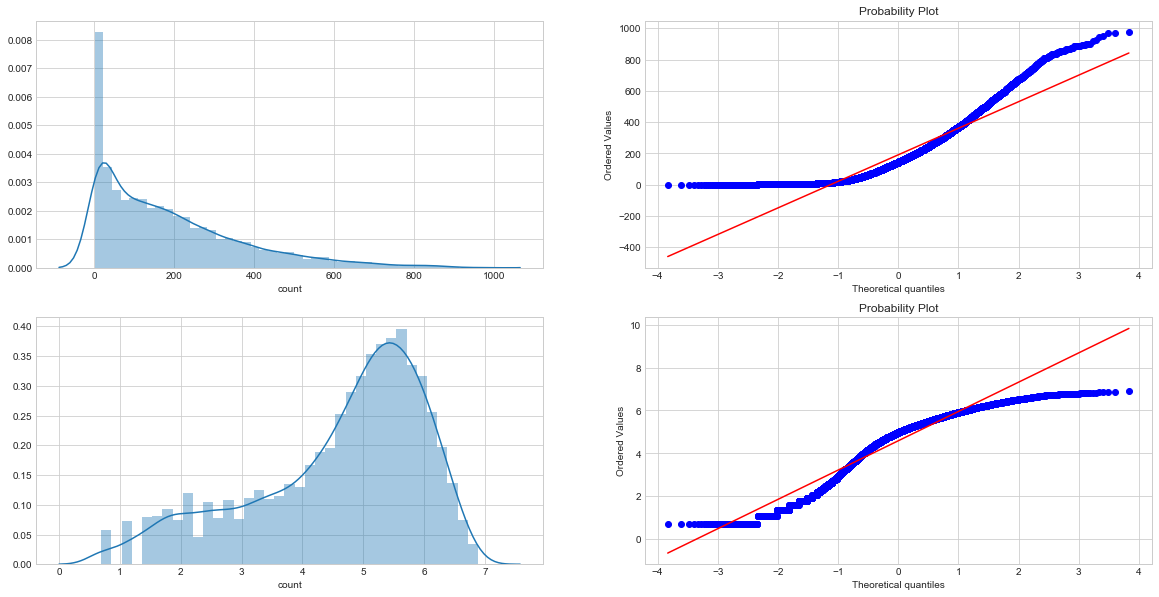

In [44]:
#log of count
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["count"],ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["count"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["count"]), dist='norm', fit=True, plot=axes[1][1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ...,  5.89164421,
          5.89440283,  5.90808294])),
 (1.4665476515913096, 2.7124391746089027, 0.98328305434919172))

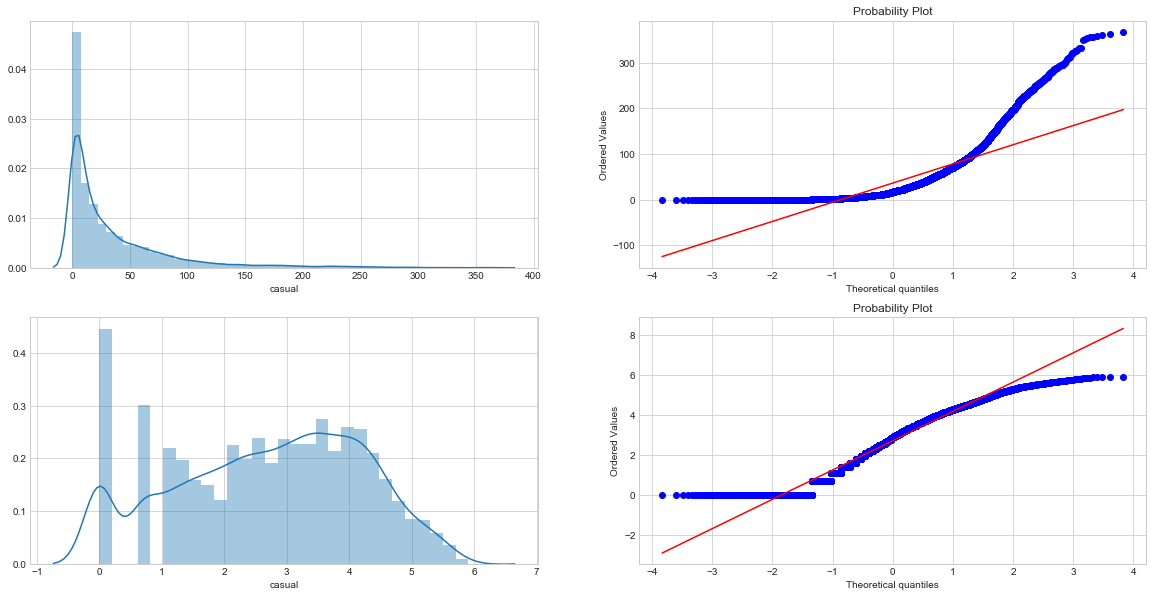

In [45]:
#log of casual
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["casual"],ax=axes[0][0])
stats.probplot(df_train["casual"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["casual"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["casual"]), dist='norm', fit=True, plot=axes[1][1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ...,  6.7546041 ,
          6.7546041 ,  6.78784498])),
 (1.3467198831590608, 4.3957742598456111, 0.96209205209993787))

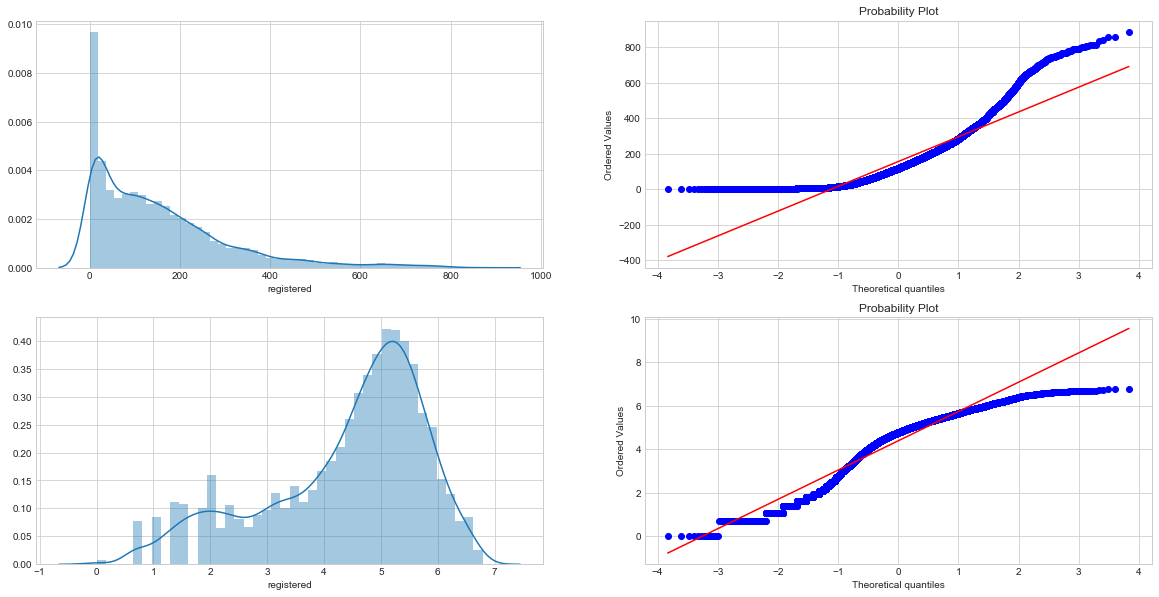

In [46]:
#log of registered
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(df_train["registered"],ax=axes[0][0])
stats.probplot(df_train["registered"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log1p(df_train["registered"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["registered"]), dist='norm', fit=True, plot=axes[1][1])

In [47]:
#Log Transform dependent variables and add to train dataset
df_train['log_casual'] = np.log1p(df_train['casual'])
df_train['log_registered'] = np.log1p(df_train['registered'])
df_train['log_count'] = np.log1p(df_train['count'])

/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [48]:
#verify the log columns added to the train dataset
df_train.shape

(10886, 22)

In [49]:
# get all the features including the new ones created for modeling
features_to_exclude = ['casual', 'registered', 'count', 'log_casual', 'log_registered', 'log_count']
features = [feature for feature in df_train.columns.values if feature not in features_to_exclude]
print features

['atemp', 'holiday', 'humidity', 'season', 'temp', 'weather', 'windspeed', 'workingday', 'year', 'hour', 'dayofweek', 'month', 'day', 'dayofyear', 'weekend', 'day_type']


In [50]:
#Feature Engineered prediction using median model
FE_median_model = DummyRegressor(strategy="median")
FE_median_preds = cross_val_predict(FE_median_model, df_train[features], df_train['count'], cv=10)

kaggle_fit_FE_median = FE_median_model.fit(df_train[features], df_train['count'])
kaggle_predict_FE_median = FE_median_model.predict(df_test[features])

FE_median_RMSLE = RMSLE(df_train['count'], FE_median_preds)
FE_median_R2 = metrics.r2_score(df_train['count'], FE_median_preds)

print 'FE median RMSLE: ', FE_median_RMSLE
print 'FE median R2: ', FE_median_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_predict_FE_median}, columns = ["datetime", "count"])
df_submission.to_csv('FE_median_bike_sharing_prediction_output.csv', index=False)

FE median RMSLE:  1.48734214938
FE median R2:  -0.0976122992241


In [51]:
#Linear regression model
FE_LR_model = LinearRegression()
FE_LR_preds = cross_val_predict(FE_LR_model, df_train[features], df_train['count'], cv=10)
FE_LR_preds[FE_LR_preds<0] = 0

kaggle_LR_fit = FE_LR_model.fit(df_train[features], df_train['count'])
kaggle_LR_predict = FE_LR_model.predict(df_test[features])
kaggle_LR_predict[kaggle_LR_predict<0] = 0

FE_LR_RMSLE = RMSLE(df_train['count'], FE_LR_preds)
FE_LR_R2 = metrics.r2_score(df_train['count'], FE_LR_preds)

print 'FE linear regression RMSLE: ', FE_LR_RMSLE
print 'FE linear regression R2: ', FE_LR_R2

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict}, columns = ["datetime", "count"])
df_submission.to_csv('FE_LR_bike_sharing_prediction_output.csv', index=False)

FE linear regression RMSLE:  1.32215661479
FE linear regression R2:  0.381875732591


In [52]:
#Linear regression model using log_count
FE_LR_model_log = LinearRegression()
FE_LR_preds_log = np.expm1(cross_val_predict(FE_LR_model_log, df_train[features], df_train['log_count'], cv=10))

kaggle_LR_fit_log = FE_LR_model_log.fit(df_train[features], df_train['log_count'])
kaggle_LR_predict_log = np.expm1(FE_LR_model_log.predict(df_test[features]))

FE_LR_RMSLE_log = RMSLE(df_train['count'], FE_LR_preds_log)
FE_LR_R2_log = metrics.r2_score(df_train['count'], FE_LR_preds_log)

print 'FE log_count linear regression RMSLE: ', FE_LR_RMSLE_log
print 'FE log_count linear regression R2: ', FE_LR_R2_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('FE_logcount_LR_bike_sharing_prediction_output.csv', index=False)

FE log_count linear regression RMSLE:  1.02189382194
FE log_count linear regression R2:  0.192965035639


From the above modeling there is a small improvement of 0.001 accuracy using the FE median model, however the linear regression 0.14 improvement in accuracy and then the using the log_count shows another improvement of 0.3 in accuracy.

### Hour, Temperature, and Month Features

The hour, temperature, and month features may be further binned to create new features that will possibly add accuracy to our modeling.

In [53]:
# Put the train and test dataset togeather to create new features
data = df_train.append(df_test)
data.shape

(17379, 22)

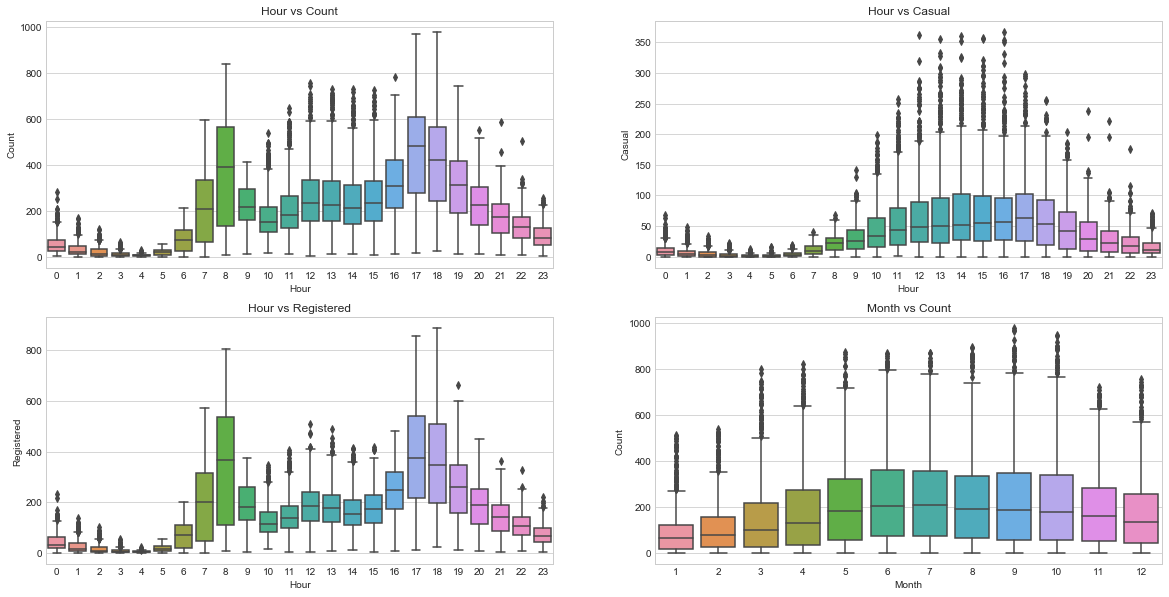

In [54]:
# Plotting the hour and month feature to decide how to bin it
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sns.boxplot(data=data,y="count",x="hour",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="casual",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="registered",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="count",x="month",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Hour', ylabel='Count',title="Hour vs Count")
axes[0][1].set(xlabel='Hour', ylabel='Casual',title="Hour vs Casual")
axes[1][0].set(xlabel='Hour', ylabel='Registered',title="Hour vs Registered")
axes[1][1].set(xlabel='Month', ylabel='Count',title="Month vs Count")

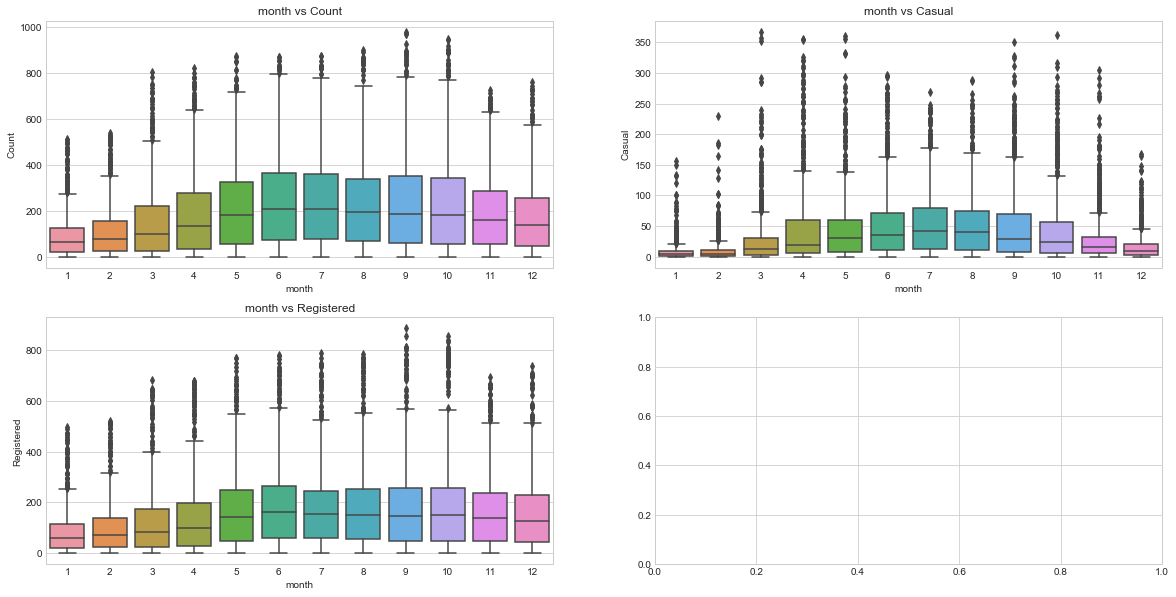

In [55]:
# Plotting the month for casual, registered, and count to decide if need to use casual and registered for seperate binning and feature creation
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sns.boxplot(data=data,y="count",x="month",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="casual",x="month",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="registered",x="month",orient="v",ax=axes[1][0])
#sns.boxplot(data=df_train,y="count",x="dayofyear",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='month', ylabel='Count',title="month vs Count")
axes[0][1].set(xlabel='month', ylabel='Casual',title="month vs Casual")
axes[1][0].set(xlabel='month', ylabel='Registered',title="month vs Registered")
#axes[1][1].set(xlabel='Day of the Year', ylabel='Count',title="Day of the Year vs Count")

In [56]:
#creating extra features for month and hour from the casual and registered variables
data['hour_reg'] = 0
data['hour_cas'] = 0
data['month_part'] = 0
data['hour_reg'] = np.where((data['hour'] < 7) | (data['hour'] > 21), 1, np.where((data['hour'] == 8) | (data['hour'] == 17) | (data['hour'] == 18), 2, 3 ))
data['hour_cas'] = np.where((data['hour'] < 7), 1, np.where(((data['hour'] > 6) & (data['hour'] < 11)) | ((data['hour'] < 24) & (data['hour'] > 10)), 2, 3 ))
data['month_part'] = np.where((data['month'] < 3), 1, np.where(((data['month'] > 2) & (data['month'] < 5)) | ((data['hour'] > 11)), 2, 3 ))
data.head()

,atemp,casual,count,day,day_type,dayofweek,dayofyear,holiday,hour,humidity,...,season,temp,weather,weekend,windspeed,workingday,year,hour_reg,hour_cas,month_part
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 05:00:00,12.880,0.0,1.0,1,0,5,1,0,5,75.0,...,1,9.84,2,1,6.0032,0,2011,1,1,1
2011-01-01 10:00:00,19.695,12.0,36.0,1,0,5,1,0,10,76.0,...,1,15.58,1,1,16.9979,0,2011,3,2,1
2011-01-01 11:00:00,16.665,26.0,56.0,1,0,5,1,0,11,81.0,...,1,14.76,1,1,19.0012,0,2011,3,2,1
2011-01-01 12:00:00,21.210,29.0,84.0,1,0,5,1,0,12,77.0,...,1,17.22,1,1,19.0012,0,2011,3,2,1
2011-01-01 13:00:00,22.725,47.0,94.0,1,0,5,1,0,13,72.0,...,1,18.86,2,1,19.9995,0,2011,3,2,1


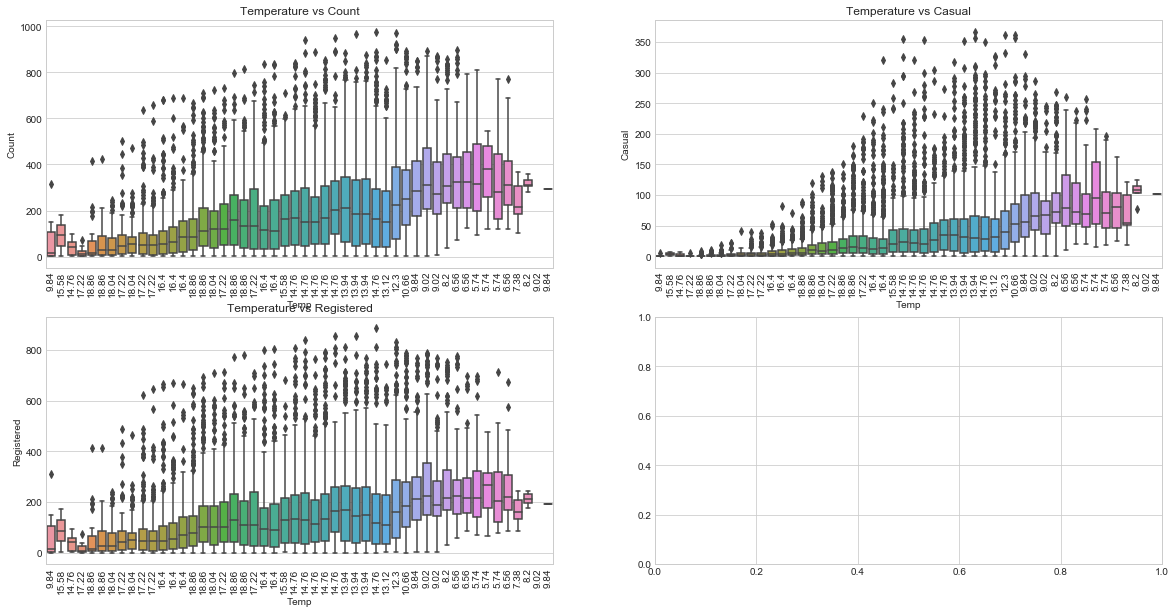

In [57]:
# Plotting temperature for casual, registered, and count to determine if need seperate features
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
a = sns.boxplot(data=data,y="count",x="temp",orient="v",ax=axes[0][0])
b = sns.boxplot(data=data,y="casual",x="temp",orient="v",ax=axes[0][1])
c = sns.boxplot(data=data,y="registered",x="temp",orient="v",ax=axes[1][0])
a.set_xticklabels(data['temp'], rotation = 90)
b.set_xticklabels(data['temp'], rotation = 90)
c.set_xticklabels(data['temp'], rotation = 90)
#sns.boxplot(data=df_train,y="count",x="dayofyear",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Temp', ylabel='Count',title="Temperature vs Count")
axes[0][1].set(xlabel='Temp', ylabel='Casual',title="Temperature vs Casual")
axes[1][0].set(xlabel='Temp', ylabel='Registered',title="Temperature vs Registered")
#axes[1][1].set(xlabel='Day of the Year', ylabel='Count',title="Day of the Year vs Count")

In [58]:
# creating new features for temp based on dependent variables casual and registered and checking all new features are present
data['temp_reg'] = 0
data['temp_part'] = 0
data['temp_reg'] = np.where((data['temp'] < 14.0), 1, np.where((data['temp'] >= 14) & (data['temp'] <= 27), 2, 3 ))
data['temp_part'] = np.where((data['temp'] < 14.0), 1, np.where((data['temp'] >= 14) & (data['temp'] <= 27), 2, 3 ))
data.head()

,atemp,casual,count,day,day_type,dayofweek,dayofyear,holiday,hour,humidity,...,weather,weekend,windspeed,workingday,year,hour_reg,hour_cas,month_part,temp_reg,temp_part
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 05:00:00,12.880,0.0,1.0,1,0,5,1,0,5,75.0,...,2,1,6.0032,0,2011,1,1,1,1,1
2011-01-01 10:00:00,19.695,12.0,36.0,1,0,5,1,0,10,76.0,...,1,1,16.9979,0,2011,3,2,1,2,2
2011-01-01 11:00:00,16.665,26.0,56.0,1,0,5,1,0,11,81.0,...,1,1,19.0012,0,2011,3,2,1,2,2
2011-01-01 12:00:00,21.210,29.0,84.0,1,0,5,1,0,12,77.0,...,1,1,19.0012,0,2011,3,2,1,2,2
2011-01-01 13:00:00,22.725,47.0,94.0,1,0,5,1,0,13,72.0,...,2,1,19.9995,0,2011,3,2,1,2,2


## Model Fitting and Tuning
### Linear Regression
Our feature engineering is now complete and we are moving on to testing different models.  We will start with the linear regression model to verify that our most recent feature engineering has improved the accuracy of our modeling. 

In [59]:
#split the data into df_train and df_test by day of the month and check that shape of the data is correct
df_train = data.loc[data['day'] < 20]
df_test = data.loc[data['day'] > 19]
print df_train.shape
#delete the count,causal,registered columns from the test data after splitting
#print df_test
df_test.drop(['casual','registered','count','log_casual','log_registered','log_count'], axis=1, inplace=True)
print df_test.shape
#print df_test

(10886, 27)
(6493, 21)


/Users/nic0lek/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [60]:
# Set new features
features_to_exclude = ['casual', 'registered', 'count', 'log_casual', 'log_registered', 'log_count']
features = [feature for feature in df_train.columns.values if feature not in features_to_exclude]
print features

['atemp', 'day', 'day_type', 'dayofweek', 'dayofyear', 'holiday', 'hour', 'humidity', 'month', 'season', 'temp', 'weather', 'weekend', 'windspeed', 'workingday', 'year', 'hour_reg', 'hour_cas', 'month_part', 'temp_reg', 'temp_part']


In [61]:
#linear regression model with log count verifying new features helped
FE_LR_model_log = LinearRegression()
FE_LR_preds_log = np.expm1(cross_val_predict(FE_LR_model_log, df_train[features], df_train['log_count'], cv=10))

kaggle_LR_fit_log = FE_LR_model_log.fit(df_train[features], df_train['log_count'])
kaggle_LR_predict_log = np.expm1(FE_LR_model_log.predict(df_test[features]))

FE_bin_LR_RMSLE_log = RMSLE(df_train['count'], FE_LR_preds_log)
FE_bin_LR_R2_log = metrics.r2_score(df_train['count'], FE_LR_preds_log)

print 'FE linear regression RMSLE: ', FE_bin_LR_RMSLE_log
print 'FE linear regression R2: ', FE_bin_LR_R2_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_LR_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('FE_LR_log_final_bike_sharing_prediction_output.csv', index=False)

FE linear regression RMSLE:  0.772874449478
FE linear regression R2:  0.469364568731


Using our new features we have improved the linear regression model by 0.25 accuracy. 

### k-Nearest Neighbors
Next we will try a k-Nearest Neighbors model.

In [64]:
# kNN model
k = 10
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = k, weights = "distance"))
knn_preds = np.expm1(cross_val_predict(knn_pipe, df_train[features], df_train['log_count'], cv=10))

kNN_RMSLE_log = RMSLE(df_train['count'], knn_preds)
kNN_R2_log = metrics.r2_score(df_train['count'], knn_preds)

print 'kNN RMSLE: ', kNN_RMSLE_log
print 'kNN R2: ', kNN_R2_log

kaggle_knn_fit_log = knn_pipe.fit(df_train[features], df_train['log_count'])
kaggle_knn_predict_log = np.expm1(knn_pipe.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_knn_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('knn_bike_sharing_prediction_output.csv', index=False)

kNN RMSLE:  0.725358074873
kNN R2:  0.686860300011


The accuracy was improved by 0.044 with k-Nearest Neighbor model.

### Decision Trees
Next we try a decision trees model.

In [65]:
# Decision Tree modeling
dt_model_log = DecisionTreeRegressor(max_depth=10)
dt_preds_log = np.expm1(cross_val_predict(dt_model_log, df_train[features], df_train['log_count'], cv=10))

dt_RMSLE_log = RMSLE(df_train['count'], dt_preds_log)
dt_R2_log = metrics.r2_score(df_train['count'], dt_preds_log)

print 'DT RMSLE: ', dt_RMSLE_log
print 'DT R2: ', dt_R2_log

kaggle_dt_fit_log = dt_model_log.fit(df_train[features], df_train['log_count'])
kaggle_dt_predict_log = np.expm1(dt_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_dt_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('dt_bike_sharing_prediction_output.csv', index=False)

DT RMSLE:  0.491481762842
DT R2:  0.803348463617


The accuracy was improved by 0.24 with decision tress regression.

### Random Forest
Next we try a Random Forest Model.

In [66]:
# Random Forest model
rf_model_log = RandomForestRegressor(n_estimators = 100, max_features = 8, max_depth = 20)
rf_preds_log = np.expm1(cross_val_predict(rf_model_log, df_train[features], df_train['log_count'], cv=10, n_jobs=-1))

rf_RMSLE_log = RMSLE(df_train['count'], rf_preds_log)
rf_R2_log = metrics.r2_score(df_train['count'], rf_preds_log)

print 'RF RMSLE: ', rf_RMSLE_log
print 'RF R2: ', rf_R2_log

kaggle_rf_fit_log = rf_model_log.fit(df_train[features], df_train['log_count'])
kaggle_rf_predict_log = np.expm1(rf_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_rf_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('rf_bike_sharing_prediction_output.csv', index=False)

RF RMSLE:  0.372127101896
RF R2:  0.900095979506


Random Forest improved the accuracy significantly by 0.12, however we may be able to do slightly better by doing parameter tuning.  

In [68]:
# Random forest paramter tuning using grid search 
rf_params = {'n_estimators': np.arange(1,30), 
             'max_features': [8],
             'max_depth': [10]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring='mean_squared_error', cv=10)
rf_grid.fit(df_train[features], df_train['log_count'])
print (np.sqrt(-rf_grid.best_score_))
print (rf_grid.best_params_)

0.415203022174
{'max_features': 8, 'n_estimators': 26, 'max_depth': 10}


The number of estimators seems to significantly affect the RMSLE, below we run the parameter tuning again with a larger range of estimators. 

In [245]:
# Random forest paramter tuning using grid search 
rf_params = {'n_estimators': np.arange(100,500,100), 
             'max_features': [8],
             'max_depth': [10]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring='mean_squared_error', cv=10)
rf_grid.fit(df_train[features], df_train['log_count'])
print (np.sqrt(-rf_grid.best_score_))
print (rf_grid.best_params_)

0.440463848045
{'max_features': 8, 'n_estimators': 400, 'max_depth': 10}


Running random forest model again with n_estimators = 400.

In [69]:
# Random Forest model tuned
rf_model_log = RandomForestRegressor(n_estimators = 400, max_features = 8, max_depth = 40)
rf_preds_log = np.expm1(cross_val_predict(rf_model_log, df_train[features], df_train['log_count'], cv=10, n_jobs=-1))

rf_tune_RMSLE_log = RMSLE(df_train['count'], rf_preds_log)
rf_tune_R2_log = metrics.r2_score(df_train['count'], rf_preds_log)

print 'RF RMSLE: ', rf_tune_RMSLE_log
print 'RF R2: ', rf_tune_R2_log

kaggle_rf_fit_log = rf_model_log.fit(df_train[features], df_train['log_count'])
kaggle_rf_predict_log = np.expm1(rf_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_rf_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('rf_tuned_bike_sharing_prediction_output.csv', index=False)

RF RMSLE:  0.368491655799
RF R2:  0.900866339127


We can see that increasing the number of estimators will decrease the RMSLE and improve accuracy, though it takes a much more time and computation resources so there is a tradeoff.  The plots below show that the gain from the number of estimators plateaus around 20 and the maximum depth around 40.

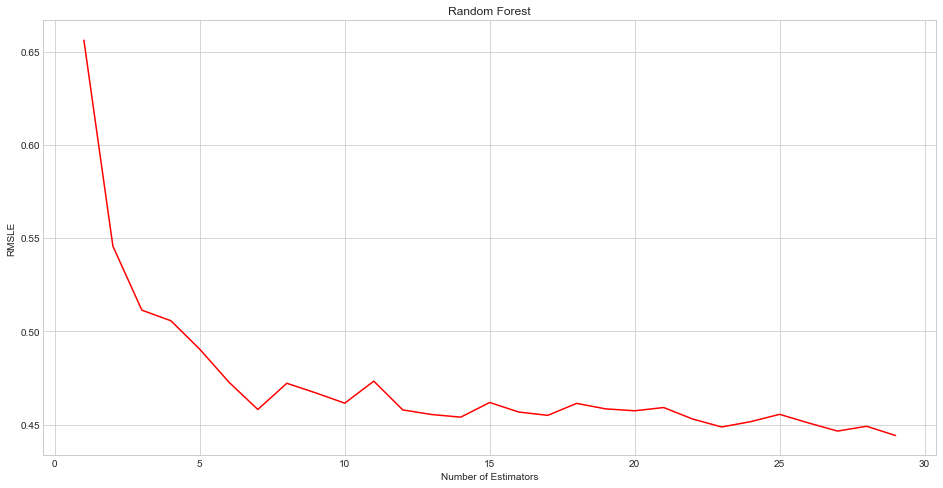

In [40]:
# Random forest plot
sns.set_style("whitegrid")
accuracies = [np.sqrt(-(rf_grid.grid_scores_[i][1])) for i in range(29)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["n_estimators"], accuracies, 'r')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Number of Estimators")
ylabel = plt.ylabel ("RMSLE")

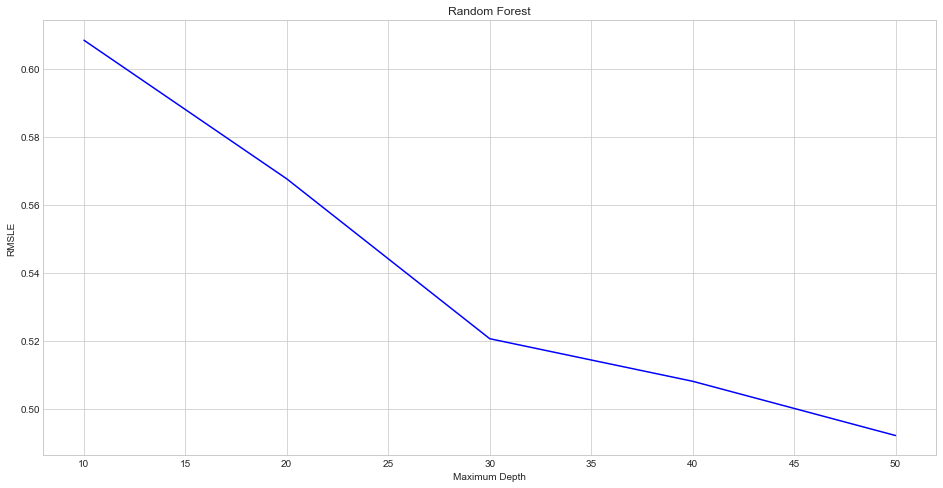

In [239]:
# Random forest plot
sns.set_style("whitegrid")
accuracies = [np.sqrt(-(rf_grid.grid_scores_[i][1])) for i in range(5)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["max_depth"], accuracies, 'b')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Maximum Depth")
ylabel = plt.ylabel ("RMSLE")

### Gradient Boost
Next we will try gradient boosting modeling.  

In [70]:
# gradient boosting modeling
gb_model_log = GradientBoostingRegressor(learning_rate=0.05, max_depth=40, min_samples_leaf=27)
gb_preds_log = np.expm1(cross_val_predict(gb_model_log, df_train[features], df_train['log_count'], cv=10))

gb_RMSLE_log = RMSLE(df_train['count'], gb_preds_log)
gb_R2_log = metrics.r2_score(df_train['count'], gb_preds_log)

print 'GB RMSLE: ', gb_RMSLE_log
print 'GB R2: ', gb_R2_log

kaggle_gb_fit_log = gb_model_log.fit(df_train[features], df_train['log_count'])
kaggle_gb_predict_log = np.expm1(gb_model_log.predict(df_test[features]))

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_gb_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('gb_bike_sharing_prediction_output.csv', index=False)

GB RMSLE:  0.332013034451
GB R2:  0.92132741918


The gradient boosting model increased the accuracy by 0.03.

### Predicting casual and registered users separately
As seen from the scatterplot matrix above, casual and registered bike users behave quite differently. We can take advantage of the split that is provided in the data. We can fit two different models to each group of users, then add them up. Doing so should improve the performance of a standalone model.

In [71]:
np.random.seed(0)

# Casual
casual_model = GradientBoostingRegressor(learning_rate=0.05, max_features=10, max_depth=40, min_samples_leaf=27)
preds_casual = np.expm1(cross_val_predict(casual_model, df_train[features], df_train['log_casual'], cv=10, n_jobs=-1))

cgb_RMSLE_log = RMSLE(df_train['casual'], preds_casual)
cgb_R2_log = metrics.r2_score(df_train['casual'], preds_casual)

print 'Casual GB RMSLE: ', cgb_RMSLE_log
print 'Casual GB R2: ', cgb_R2_log

kaggle_casual_fit_log = casual_model.fit(df_train[features], df_train['log_casual'])
kaggle_casual_predict_log = np.expm1(casual_model.predict(df_test[features]))

# Registered
reg_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_features=10, max_depth=40, min_samples_leaf=27)
preds_reg = np.expm1(cross_val_predict(reg_model, df_train[features], df_train['log_registered'], cv=10, n_jobs=-1))

rgb_RMSLE_log = RMSLE(df_train['registered'], preds_reg)
rgb_R2_log = metrics.r2_score(df_train['registered'], preds_reg)

print 'Registered GB RMSLE: ', rgb_RMSLE_log
print 'Registered GB R2: ', rgb_R2_log

kaggle_registered_fit_log = reg_model.fit(df_train[features], df_train['log_count'])
kaggle_registered_predict_log = np.expm1(reg_model.predict(df_test[features]))

#Registered + Casual
preds_total = preds_casual + preds_reg

rcgb_RMSLE_log = RMSLE(df_train['count'], preds_total)
rcgb_R2_log = metrics.r2_score(df_train['count'], preds_total)

print 'Registered + Casual GB RMSLE: ', rcgb_RMSLE_log
print 'Registered + Casual GB R2: ', rcgb_R2_log
#print preds_total.shape

kaggle_count_predict_log = kaggle_registered_predict_log + kaggle_casual_predict_log

df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_gb_predict_log}, columns = ["datetime", "count"])
df_submission.to_csv('gbrc_bike_sharing_prediction_output.csv', index=False)

Casual GB RMSLE:  0.509837223865
Casual GB R2:  0.871512225139
Registered GB RMSLE:  0.312382815046
Registered GB R2:  0.941446739611
Registered + Casual GB RMSLE:  0.31311850463
Registered + Casual GB R2:  0.938600671874


Modeling casual and registered separately provided a slight improvement in accuracy of 0.02.

## Error Analysis

From the plots below we can see how well each of our models predicted the actual test data (black line).  It looks like for most of the models we are we are underfitting in the beggining and overfitting at the end with the exception of the linear regression model which has a very poor fit.  

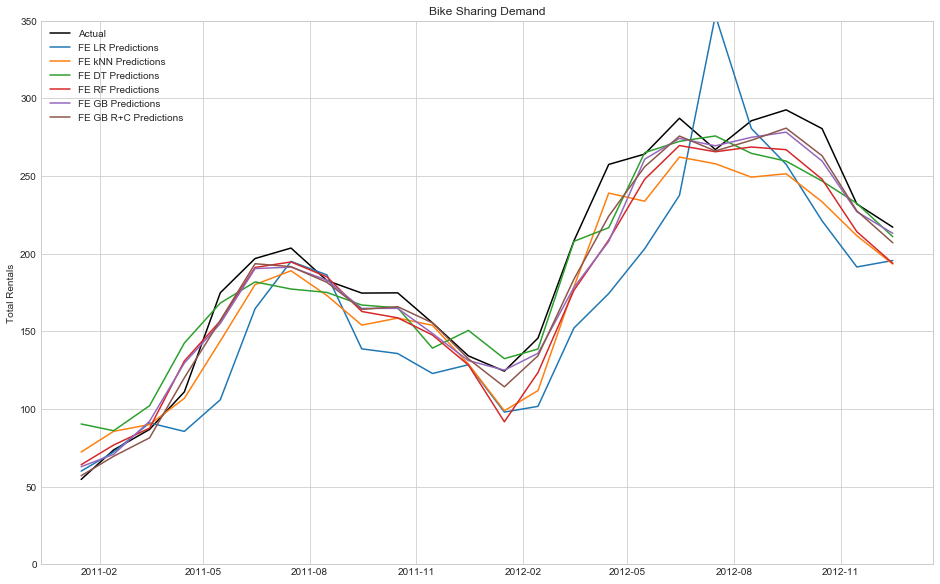

In [72]:
# Compare a monthly mean version of predictions with the actual figures
df_monthlymean = df_train.resample('M').mean()

df_preds_lr = pd.DataFrame({'FE_LR_preds_log':FE_LR_preds_log}, index=df_train.index)
df_preds_lr_monthly = df_preds_lr.resample('M').mean()

df_preds_knn = pd.DataFrame({'knn_preds':knn_preds}, index=df_train.index)
df_preds_knn_monthly = df_preds_knn.resample('M').mean()

df_preds_dt = pd.DataFrame({'dt_preds_log':dt_preds_log}, index=df_train.index)
df_preds_dt_monthly = df_preds_dt.resample('M').mean()

df_preds_rf = pd.DataFrame({'rf_preds_log':rf_preds_log}, index=df_train.index)
df_preds_rf_monthly = df_preds_rf.resample('M').mean()

df_preds_gb = pd.DataFrame({'gb_preds_log':gb_preds_log}, index=df_train.index)
df_preds_gb_monthly = df_preds_gb.resample('M').mean()

df_preds = pd.DataFrame({'preds_total':preds_total}, index=df_train.index)
df_preds_monthly = df_preds.resample('M').mean()

# Plot
plt.figure(figsize = (16,10))
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Actual", color = 'black')
lr_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_lr_monthly['FE_LR_preds_log'], label="FE LR Predictions")
knn_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_knn_monthly['knn_preds'], label="FE kNN Predictions")
dt_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_dt_monthly['dt_preds_log'], label="FE DT Predictions")
rf_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_rf_monthly['rf_preds_log'], label="FE RF Predictions")
gb_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_gb_monthly['gb_preds_log'], label="FE GB Predictions")
gbrc_predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_monthly['preds_total'], label="FE GB R+C Predictions")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
yaxis = plt.ylim(0,350)
legend = plt.legend(frameon=False)

## Results Predicting Test Data 
We submitted our best model which can be seen below is the FE gradient boosted model that used the registered + causal = count and got a score back of 0.43855, which gave us a rank of 740/3215 = 23%

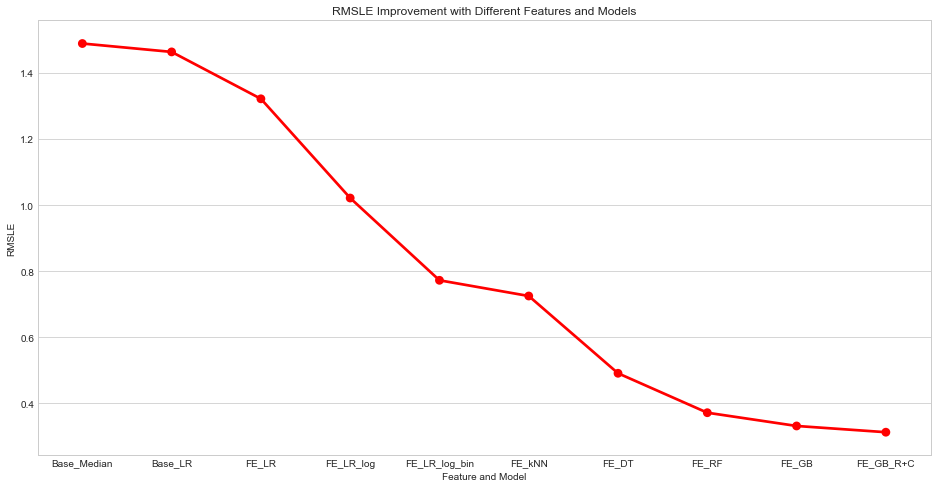

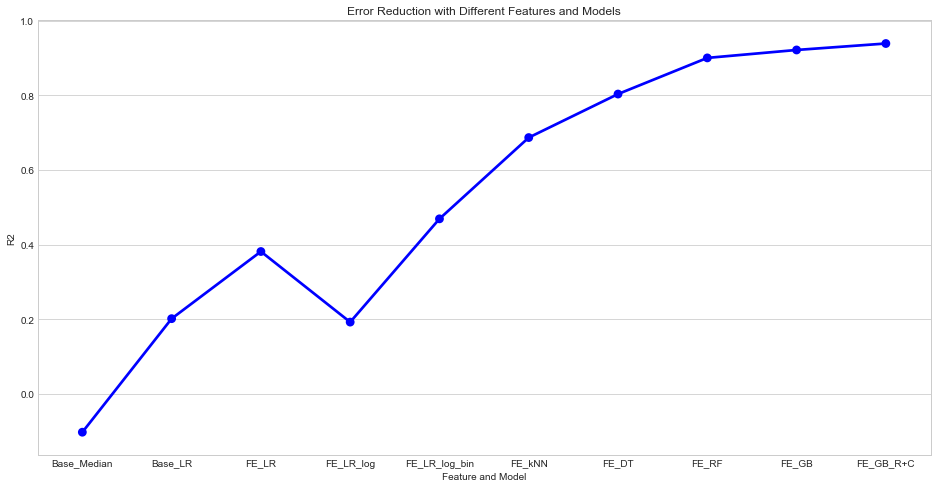

In [73]:
#summary of RMSLE scores and R2 scores
results = pd.DataFrame({'model_names': ['Base_Median', 'Base_LR', 'FE_LR', 'FE_LR_log', 'FE_LR_log_bin', 'FE_kNN', 'FE_DT', 'FE_RF', 'FE_GB', 'FE_GB_R+C'],
                            'rmsle': [base_median_RMSLE, base_LR_RMSLE, FE_LR_RMSLE, FE_LR_RMSLE_log, FE_bin_LR_RMSLE_log, kNN_RMSLE_log, dt_RMSLE_log, rf_RMSLE_log, gb_RMSLE_log, rcgb_RMSLE_log],
                            'r2': [base_median_R2, base_LR_R2, FE_LR_R2, FE_LR_R2_log, FE_bin_LR_R2_log, kNN_R2_log, dt_R2_log, rf_R2_log, gb_R2_log, rcgb_R2_log]})
    
sns.set_style('whitegrid')
# plot RMSLE
plt.figure(figsize=(16,8))
sns.pointplot(x='model_names', y='rmsle', data=results, color='r')
title = plt.title('RMSLE Improvement with Different Features and Models')
xlabel = plt.xlabel('Feature and Model')
ylabel = plt.ylabel("RMSLE")
# Plot R2
plt.figure(figsize=(16,8))
sns.pointplot(x='model_names', y='r2', data=results, color='b')
title = plt.title('Error Reduction with Different Features and Models')
xlabel = plt.xlabel('Feature and Model')
ylabel = plt.ylabel("R2")

# Part 2: Predicting Future Rentals from Past Data 

In the last part of our project we explore a scenario where a bicycle rental company which has been around for a few years and is looking to optimize their bike rentals over various sites in a city.  From day to day, different amounts of bikes are rented based on a number of factors, and accurate prediction of that number will allow for bikes to be redistributed among sites, leading to a higher use rate and more profits.  The initial dataset will be that of the rentals per hour at the site, and corresponding date/time information and related weather factors.  After the initial model is created, “on-line” features will be implemented, allowing new data to be used in prediction of future data.

This scenario differs from that of the Kaggle competition in a few key ways.  One, the Kaggle competition requests that test data only be predicted based on previous training data from a temporal standpoint.  As such, it makes its “test set” the times relating to days at the end of the month, and its training set the days at the beginning of the month, instead all the data will all be considered in the past and fair to use as one large dataset for this analysis.  The on-line aspect will be handled by using a subset of previous data as a factor to predict future data.  This assumption has one downside in that aspects of the dataset are removed, making some methods or ideas difficult if not impossible to implement.  This will be discussed more in future sections, such as factor generation.


### Loading the Data

In [2]:
#loading the data again to start new fresh analysis
def transform_raw_data(raw_input):
    #Putting Data into Pandas dataframe
        Column_Headers = csvfile.readline().split(',')
        Column_Headers[-1] = "count"
        csvfile.next()
        train_data = []
        for row in csvfile:
            new_row = row.replace('\n', '')
            train_data.append(new_row.split(','))
        
        df = pd.DataFrame(data = train_data[1:-1], columns = Column_Headers)
        return df

In [3]:
with open('train.csv') as csvfile:
    train_data = transform_raw_data(csvfile)
with open('test.csv') as csvfile:
    test_data = transform_raw_data(csvfile)

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
1,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
2,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1
3,2011-01-01 05:00:00,1,0,0,2,9.84,12.88,75,6.0032,0,1,1
4,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0,2,0,2


### Feature Engineering 
Date/time is a string which contains the year, month, day and hour information in a single feature, and is split into a separate feature for each of those variables in integer format.  Next, categorical variables for season and weather are one-hot encoded into logical features for the corresponding categories.

In [4]:
##Feature Modification
def modify_factors(input_data):
    output_data=pd.DataFrame(input_data)
    
    ##Split datetime into year, month, day, and hour columns
    rawdate = input_data['datetime']
    
    #Initialize new columns
    output_data['year']=0
    output_data['month']=0
    output_data['day']=0
    output_data['hour']=0
    output_data['past_hour']=0 
    
    for i in range(len(rawdate)):
        print 'working'
        #Use number of rentals for previous day/hour as predictors
        if i>=1:
            output_data['past_hour'].iloc[i]=output_data['count'].iloc[i-1]
        
        [date,hour] = rawdate.iloc[i].split()
        [year,month,day] = date.split("-")
        
        output_data['year'].iloc[i] = int(year)
        output_data['month'].iloc[i]=int(month)
        output_data['day'].iloc[i]=int(day)
        output_data['hour'].iloc[i]=int(hour[:2])
        
        
        #Split day into before, during and after work periods (after work in "intercept")
        output_data['before_work']=0
        output_data['during_work']=0
        
        if output_data['hour'].iloc[i]<9: 
            output_data['before_work'].iloc[i]=1
        elif output_data['hour'].iloc[i]<=17:
            output_data['during_work'].iloc[i]=1
            
        
    ##One hot encoding for season, weather
    season_onehot = pd.get_dummies(input_data['season'])
    season_onehot.columns = ["winter", "spring", "summer", "autumn"]
    output_data = pd.concat([output_data,season_onehot],axis=1)
    
    weather_onehot = pd.get_dummies(input_data['weather'])
    weather_onehot.columns = ["clear", "misty", "light_precip", "heavy_precip"]
    output_data = pd.concat([output_data,weather_onehot],axis=1)

    
    del output_data['datetime']
    del output_data['season']
    del output_data['weather']
    
    #Remove Dependent Columns
    del output_data['clear']
    del output_data['spring']
    
    return output_data

In [5]:
train_data = modify_factors(train_data)

working


/Users/nic0lek/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [6]:
train_data.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,...,hour,past_hour,before_work,during_work,winter,summer,autumn,misty,light_precip,heavy_precip
0,0,0,9.02,13.635,80,0,5,27,32,2011,...,2,0,0,0,1,0,0,0,0,0
1,0,0,9.84,14.395,75,0,3,10,13,2011,...,3,32,0,0,1,0,0,0,0,0
2,0,0,9.84,14.395,75,0,0,1,1,2011,...,4,13,0,0,1,0,0,0,0,0
3,0,0,9.84,12.88,75,6.0032,0,1,1,2011,...,5,1,0,0,1,0,0,1,0,0
4,0,0,9.02,13.635,80,0,2,0,2,2011,...,6,1,0,0,1,0,0,0,0,0


In [16]:
train_data.to_csv('train_data.csv')

In [7]:
#Splitting Columns into Prediction and Numerical vs Categorical
All_Columns = list(train_data.columns.values)
Prediction_Columns = All_Columns[:]
Prediction_Columns.remove('registered')
Prediction_Columns.remove('casual')
Prediction_Columns.remove('count')
Numerical_Predictors = Prediction_Columns[0:10 or None]
Categorical_Predictors = Prediction_Columns[11:-0 or None]

##Removing Time based factors
Standard_Prediction_Columns = Prediction_Columns[:]
Standard_Prediction_Columns.remove('hour')
Standard_Prediction_Columns.remove('day')
Standard_Prediction_Columns.remove('month')
Standard_Prediction_Columns.remove('year')

### Modeling
The nature of the problem dictates use of a supervised learning method with regression rather than classification output.  These conditions lead to the following options as possibilities:
- Linear Model
- Bayesian Model
- Tree Model

Before any modeling can occur, the data set must be split into training, test and dev (where applicable).  Based on each set being a desired percentage of the overall data, a random split was used, rather than using the first X % of the data for training as an example.  This was done to more accurately capture the time component of the data and not overfit aspects.  After some testing, a good split was found using 80% training data and 20% test data.

In [8]:
#train, dev, test split of base data
def data_split(data,train_percent,dev_percent,is_random):
    size_of_data=len(data)
    train_amount=int(round(train_percent*size_of_data))
    dev_amount=int(round(dev_percent*size_of_data))
    train, dev, test = np.split(data.sample(frac=1), [train_amount, train_amount+dev_amount])
    return train,dev,test

In [9]:
[train_set,dev_set,test_set]=data_split(train_data,.8,0.0,1)

In [10]:
##Function to determine model fit quality
def fit_evaluation(actual,predicted):
    intval = 0.0
    amount = len(predicted)
    for i in range(len(predicted)):
        intval+=(math.log(float(predicted[i])+1.0)-math.log(float(actual[i])+1.0))**2
    val = (1/float(amount)*intval)**.5
    return val

In [11]:
##Convert that function into a modified scorer
from sklearn.metrics import fbeta_score,make_scorer
from sklearn.dummy import DummyClassifier

log_score = make_scorer(fit_evaluation,greater_is_better=False)

### Linear Regression 
The linear model does not perform well.  The limited number of factors does not lend well to effectively capturing the variability in the output.  In addition, the model predicts some negative outputs, which is not possible, but also does not allow for use of RMSLE as an evaluation criterion to the quality of the model.  Below is a plot of the actual vs predicted counts of the test data using the linear model.  The most obvious aspects of this plot are the widening variance in results as the number of counts increases, and the fact that the model grossly underestimates the counts in many instances.  Ideally the mean line of the data points would have slope one, but this is far from the case.  In fact, the predicted counts never exceed 800, while actual accounts do to a reasonable number.  

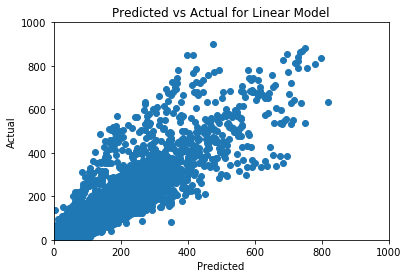

In [20]:
#Basic Linear Regression
LinearReg = LinearRegression()
LinearReg.fit(train_set[Prediction_Columns], train_set['count'])
##print LinearReg.score(test_set[Prediction_Columns], test_set['count'])

predicted = LinearReg.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual for Linear Model')
##print fit_evaluation(test_set['count'].values,predicted)

### Multinode Naive Bayes Model
The Naïve Bayes model performs better than the linear model but still leaves some aspects to be desired.  A plot of the predicted vs actual counts is given below.  It improves upon the linear model but no longer predicting negative numbers of rentals, and also predicts counts in a range closer than actual values.  However this comes at a cost of having more outliers than the linear model (greatly mis-predicted values), and still having a similar “cone” of variance.  The RMSLE for this model on the test data is ~.71.  For the above reasons this model was not selected for further study.

0.707540223289


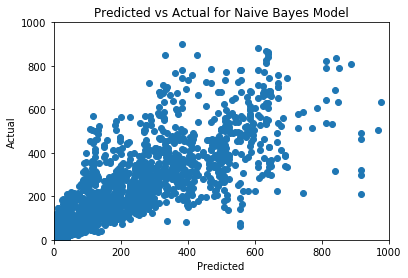

In [13]:
#Multinomial Naive Bayes
MultiBayes = MultinomialNB()
MultiBayes.fit(train_set[Prediction_Columns], train_set['count'])

predicted = MultiBayes.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual for Naive Bayes Model')
print fit_evaluation(test_set['count'].values,predicted)

### Decision Trees Model
The tree based model by comparison preformed well.  A plot of the predicted vs actual is given below and shows improvement in the variability of the predictions across the entire space.  There are some outliers, but still fewer than that of the Bayesian model.   There still appears to be some skew toward underpredicting counts, but that is less visible in this model than the two previous.  As such this type of model is selected for further study and will likely see improvement.  For comparison, the RMSLE value of this model on the test set is ~.378, showing market improvement over the Bayesian one.

0.378851432871


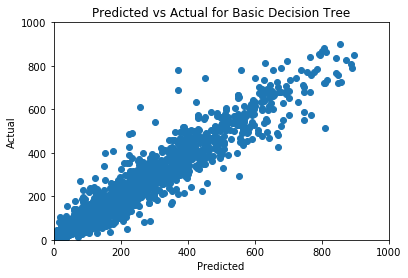

In [14]:
#Decision Trees
DTree = tree.DecisionTreeRegressor()
DTree.fit(train_set[Prediction_Columns], train_set['count'])

predicted = DTree.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual for Basic Decision Tree')
print fit_evaluation(test_set['count'].values,predicted)

### Model Tuning
In order to improve the model above, various options in the creation of the model are explored in order to find the best mix of model variability and bias.  In laymen’s terms we want the model to have enough modeling power to capture the important features of the dataset, without having so much that it overfits and is poor on the test case.  A grid search was performed over the max_depth and max_features areguments of the tree.  By implementing the RMSLE equation as a custom scoring function, the search is insured to choose the best model for the evaluation of this problem.  This technique also has another attractive quality, and that is the use of cross validation.  This allows us to use the training data as both training and development without overfitting, allowing for a larger chunk of the total data to be used as training.
The result of these found the following factors as the best model:
- max_features: 18
- max_depth: 10
- number of folds (cv): 7

A plot of this model on the test set is given below.  This model is similar to the unrefined tree model, but appears to be more compact around the mean line with fewer outliers.  There is still some noticeable skew toward under prediction of values.  The RMSLE value for this model on the test set is ~.332, showing improvement on the previous tree model.

In [15]:
param_grid = {'max_depth':range(1,20),'max_features':range(1,20)}
PTree = tree.DecisionTreeRegressor()
param_search = GridSearchCV(PTree,param_grid,cv=7,scoring=log_score)
param_search.fit(train_set[Prediction_Columns].values, train_set['count'].values)
predicted = param_search.predict(train_set[Prediction_Columns])

{'max_features': 17, 'max_depth': 9}
0.305116654439


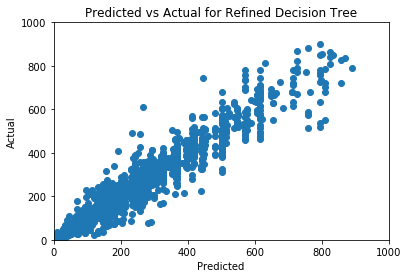

In [17]:
print param_search.best_params_
predicted = param_search.predict(test_set[Prediction_Columns])

plt.scatter(predicted,test_set['count'].values)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual for Refined Decision Tree')
print fit_evaluation(test_set['count'].values,predicted)

## Results Predicting Future Rentals

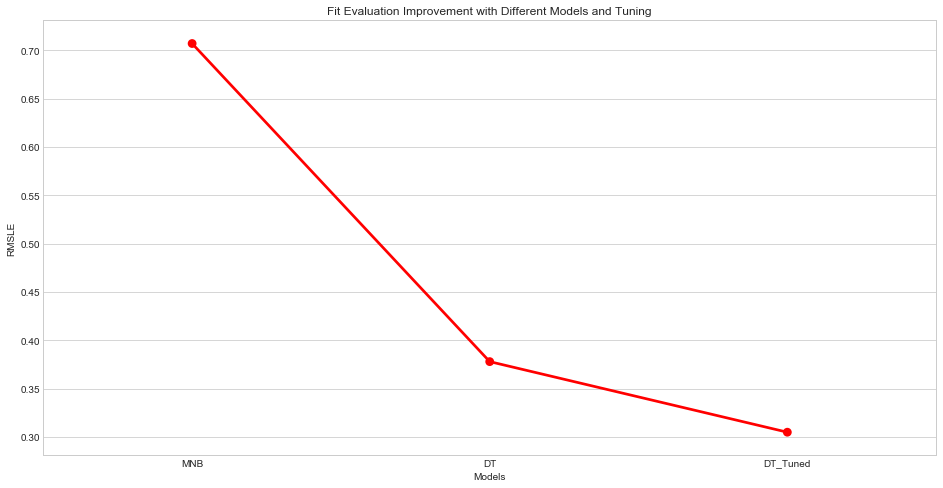

In [21]:
#summary of RMSLE scores and R2 scores
attribution = pd.DataFrame({'model_names': ['MNB', 'DT', 'DT_Tuned'],
                            'rmsle': [0.707, 0.378, 0.305]})
    
sns.set_style('whitegrid')
# plot RMSLE
plt.figure(figsize=(16,8))
sns.pointplot(x='model_names', y='rmsle', data=attribution, color='r')
title = plt.title('Fit Evaluation Improvement with Different Models and Tuning')
xlabel = plt.xlabel('Models')
ylabel = plt.ylabel("RMSLE")

The best model found was a tree based one, which was further refined using grid searches over an array of parameters.  Cross validation allowed for a larger amount of the data to be used in the creation of this model, while also protecting from overfitting.  The advantages of this model are accuracy and greater level of predicted variance compared to the Bayes and Linear models.  The downside of using a tree based model is that there is less clear meaning into the model.  Implementation is easy however, as simple branching checks on factors will yield a final answer.

# Conclusions
In Conclusion, feature engineering and model tuning were an important part of improving the prediction accuarcy for any given model.  Our feature engineering consisted of creating new features based on the datetime column, imputing windspeed and humidity to fill in missing values, log transforming our depedent variables, and finally creating more new features by binning hour, temperature, and month by casual and registered user.  The linear regression model was used as a baseline to verify our feature engineering was improving our accuracy.  We then evaluated several different models, kNN, multinode naive bayes, decision trees, random forests, and gradient boosting.  Using this process we improved our score from We managed to improve from the model error of 1.48 to 0.31, with a final score of 0.43855, which gave us a rank of 740/3215 = 23%.  This is comparable to final error that we achieved with decision trees when predicting future rentals of 0.31.

A feature of all the models in general is the tendency for the predicted number of rentals to be lower than the actual ones.  This fact may be more advantageous compared to overpredicting the actual counts, as this would mean that the number of bikes would more likely being too few rather than too many, indicating that all the bikes are rented.  However, this may cause some customer dissatisfaction if many people who would otherwise rent a bike cannot.  

Overall, the models generated do a reasonable job of predicting the complicated problem with a relatively low number of factors available.  A more complete initial data set would allow for more factors to be generated and could only improve future models.  For part 2 the model would be valuable to be able to predict and reallocate assets to various locations, ensuring that the percentage of bikes rented (and therefore profits) are as high as possible.

## Future Work
We think that future work should be focused on a few key areas:

- Additional data collection: we could collect addtional data such as pollution, traffic, demographics, etc. to create new features that would improve accuracy of predictions.

- Modeling and tuning: we could investigate more advanced modeling techniques such as deep learning or AI algorithms and if we have more time or computational power can perfect the tuning of our parameters to improve accuracy of predictions.  

- Feature Engineering: Much more could be done with feature engineering, possibly using modeling to bin and select the most important features for predictions.  

## Appendix
Started to work with Keras Deep Learning Neural Networks library to see if we could use it for modeling